In [1]:
!pip install py3Dmol


[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import copy
import numpy as np

# Qamuyを使った量子コンピュータｘ量子化学計算
ここからはより発展的なアルゴリズムを用いた計算を実行していただきたいと思います。
今回はQunaSys社が開発しているCloudサービスQamuyを使います。
Qamuyには、実用的な化学計算では不可欠な物質の物性値を計算する機能や励起状態計算法などが搭載されています。
これらの機能を使い、ハンズオンの残りの時間で以下の項目を実施します。

0. Qamuyを使った分子のエネルギー計算
1. 分子構造の最適化
2. 分子振動の計算
3. 簡単な化学反応の計算
4. 励起状態計算


なお、Qamuyのマニュアルは以下のURLにあります。
https://qamuy.qunasys.com/docs/ja/


Qamuyはcloudサービスなので、まず、以下のように、cloudサービスに接続するためのモジュールとして"Client"を、インプット作成用と解析用にqamuy.chemistryとqamuy.plotを、それぞれインポートします。Clientのemail_addressとpasswordに関しては本ハンズオンのために用意されたものを当日お伝えします。

In [3]:
import qamuy.chemistry as qy
import qamuy.plot
from qamuy.client import Client

# You can fill in your e-mail address and password.
client = Client(email_address="", password="")

## 0.Qamuyを使った分子のエネルギー計算
では、次にQamuyを実際に使って、水素分子のVQE計算を実行していただきます。まず以下のようにインプットを作ります。
まずは分子の情報の設定から。

In [4]:
input = qy.QamuyChemistryInput()

molecule = input.target_molecule
molecule.geometry = qy.molecule_geometry(["H", "H"], [[0.0, 0.0, 0.0], [0.0, 0.0, 1.0]]) #分子の構造
molecule.basis = "6-31g" #基底関数
molecule.multiplicity = 1 #スピン多重度
molecule.sz_number = 0.0 #トータルスピン
molecule.num_excited_states = 0 #励起状態をいくつ計算するか
molecule.cas = qy.cas(2, 2) # 活性電子と活性軌道の数。

次に、量子回路と量子アルゴリズムの設定をします。

In [5]:
input.solver.type = "VQE" #実行する量子古典ハイブリッドアルゴリズムの指定。ここではVQEを仕様
input.ansatz.type = "SYMMETRY_PRESERVING" #波動関数モデル（Ansatz)として使う量子回路の指定。symmetry_preservingは粒子数を保存する回路。
input.ansatz.depth = 4 #上記回路の深さを指定。深いほど表現能力はあがるが、パラメータが増えて最適化が困難になり、ノイズにも弱くなる。
input.ansatz.use_random_initial_guess = True #初期値を乱数で用意
input.ansatz.reference_state = "RHF" #インプット波動関数にRestricted Hartree Fock (全ての占有軌道が二重占有されていると仮定した平均場近似)
input.optimizer.type = "BFGS" #量子回路の最適化アルゴリズム。
input.quantum_device.type = "EXACT_SIMULATOR" #量子回路のシミュレーション方法。EXACT_SIMULATORは統計誤差もないシミュレーションを仮定。
input.ansatz.is_state_real = True #波動関数が実数と仮定

ここまででVQE計算のインプットができたので、このインプットをサーバに投入し、結果を得ます。

In [6]:
job = client.submit(input) #インプットをcloudサーバに投入
results = client.wait_and_get_job_results([job]) #結果を得る。サーバの混み具合では暫く待つ。
output = results[0].output

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   22.1s finished


得られた結果を使いVQEの最適化の様子をプロットしてみます。

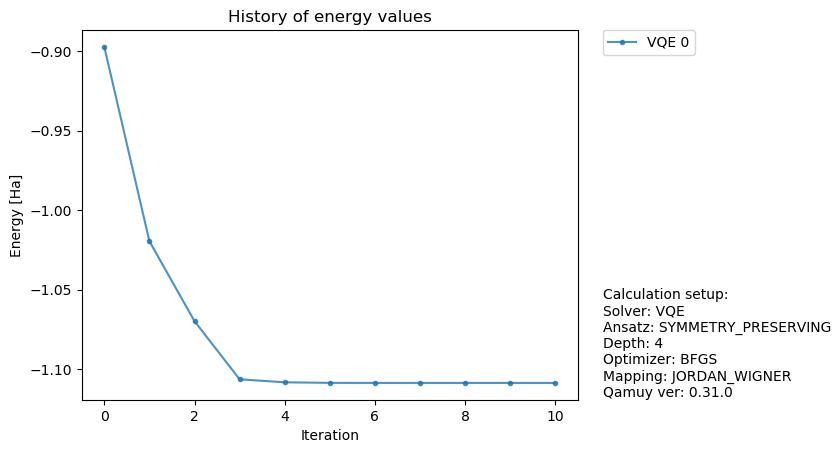

In [7]:
q_result = output.molecule_result.quantum_device_result
vqe_log = q_result.vqe_log
#VQEの最適化の様子をプロット
fig, ax = qamuy.plot.plot_energy_history(output)
fig

では、次にVQE計算の設定を少し変えてみましょう。ここでは、シミュレータを変更し、量子コンピュータ実機と同様にサンプリングおこなう形式のシミュレータを使ってみます。このシミュレータを使うことで、実際の量子コンピュータと同様に統計誤差が乗った計算が実施できます。なお、EXACT_SIMULATORはサンプリングシミュレータのサンプリング数が無限大になったものに相当する結果を与えるものとなっています。

In [8]:
input.quantum_device.type = "SAMPLING_SIMULATOR" #サンプリングシミュレータ
input.sampling_strategy.num_shots_per_term = 1000 #ハミルトニアンの各タームのサンプリング回数（デフォルトは1000)

In [9]:
job = client.submit(input)
results = client.wait_and_get_job_results([job])
output = results[0].output

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   21.4s finished


計算結果を見てみると、統計誤差（sample_stdとして表示)があることに気がづくかと思います。

In [10]:
qy.get_evaluated_property(output.molecule_result.quantum_device_result, 
                                    "energy")

{'values': [{'value': -1.109877263950912, 'sample_std': 0.010557892245578524, 'state': 0}], 'metadata': {'elapsed_time': 0.006309037999017164, 'success': True}}

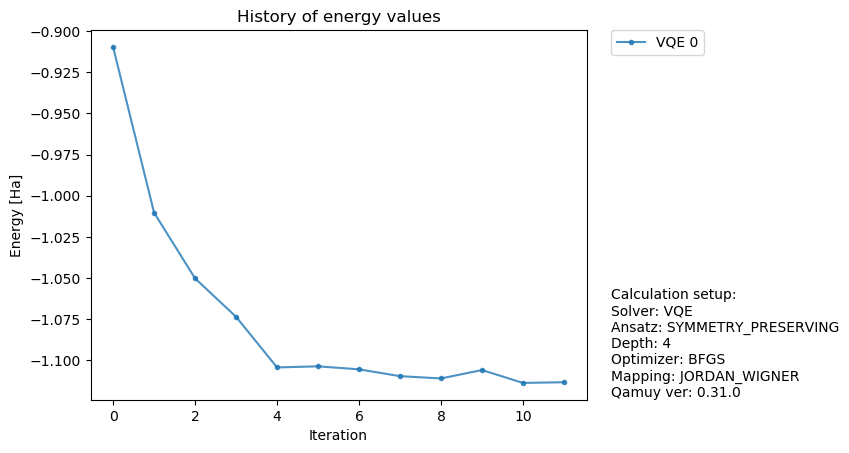

In [11]:
q_result = output.molecule_result.quantum_device_result
vqe_log = q_result.vqe_log
#VQEの最適化の様子をプロット
fig, ax = qamuy.plot.plot_energy_history(output)
fig

統計誤差があることで、量子回路パラメータ最適化の様子も変化します。では、もっとショット数をへらすとどうなるでしょうか？

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   16.1s finished


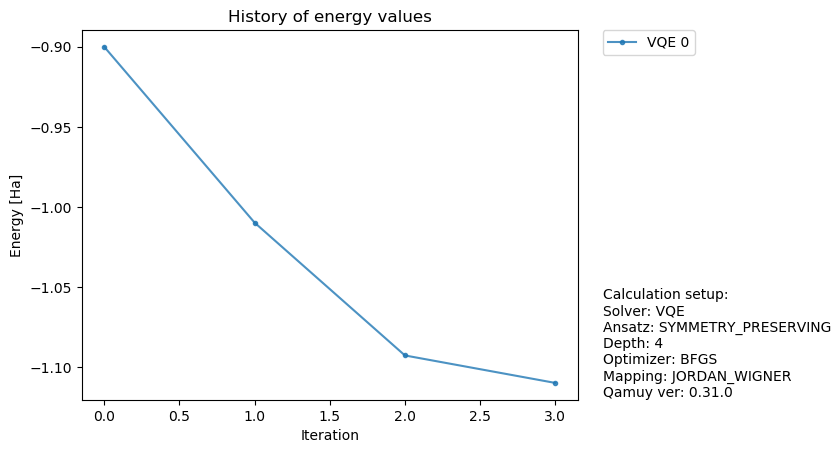

In [12]:
input.sampling_strategy.num_shots_per_term = 100
job = client.submit(input)
results = client.wait_and_get_job_results([job])
output = results[0].output
q_result = output.molecule_result.quantum_device_result
vqe_log = q_result.vqe_log
#VQEの最適化の様子をプロット
fig, ax = qamuy.plot.plot_energy_history(output)
fig

In [13]:
qy.get_evaluated_property(output.molecule_result.quantum_device_result, 
                                    "energy")

{'values': [{'value': -1.1095687683485191, 'sample_std': 0.03312080742072729, 'state': 0}], 'metadata': {'elapsed_time': 0.006351438001729548, 'success': True}}

化学で必要な精度は、1.0E-03のオーダーであることから、VQEを用いた量子化学計算では統計誤差を抑えるには沢山のサンプル数（ショット数）が必要となることがわかります。

## 1. 分子構造の最適化
さて、次に量子化学計算における最頻出のタスクともいえる、分子構造の最適化をQamuyを用いて実施します。
さきほどの水素分子の例では、適当な分子構造を入力したが、この値（分子構造、分子を構成する各原子の座標）をどう決めるのか？と疑問に思われた方も多いかと思います。
化学において意味のある（解析に用いるべき）構造は、
ほとんどの場合、分子のエネルギー $E$ を分子の構造 $R$ の関数 $E(R)$ としてしてみた場合の極小点と一次の鞍点（１自由度方向にだけ極大、他の自由度に対しては極小点となっている点）になります。
これは室温の持つエネルギーは大きくなく、分子は極小点近傍にいると考えるのが妥当だからです。

このような背景から、化学の基本は $\frac{\partial E(R)}{\partial R}=0$ 
を満たす構造 $R_{opt}$ を探すことになっています。
ある適当な初期構造 $R_{init}$ から初めてこうした安定な構造を見つけることを構造最適化（geometry optimziation)と量子化学ではよく呼びます。

この構造最適化にはエネルギーの原子核座標微分 $\frac{\partial E(R)}{\partial R_i}$ が必要になってきますが、Qamuyにはその計算を解析的におこなう機能が実装されています。
この機能を使って、まずは水の構造最適化をしてみましょう。

第一ステップは適当な水の構造をインプットとして用意することです。

In [14]:
input = qy.QamuyChemistryInput()

molecule = input.target_molecule
molecule.geometry = qy.molecule_geometry(["H", "O", "H"], [[0.0, 0.0, -1.0], [0.0, 0.0, 0.0],[0.0, -0.1, 1.0]]) #適当な分子構造
molecule.basis = "6-31g" #基底関数
molecule.multiplicity = 1 
molecule.sz_number = 0.0
molecule.num_excited_states = 0
molecule.cas = qy.cas(2, 2)

In [15]:
# save xyz string as an xyz file
init_geom_h2o = molecule.geometry
with open("initial_h2o.xyz", "w") as f:
    f.write(qy.geometry_to_xyz(molecule.geometry))

次にエネルギー計算と同様に量子回路の設定などをおこないます。

In [16]:
# Solver
input.solver.type = "VQE"

# Anasatz
input.ansatz.type = "SYMMETRY_PRESERVING"
input.ansatz.is_state_real = True
input.ansatz.reference_state = "RHF"
input.ansatz.depth = 4
input.ansatz.use_random_initial_guess = True

# Optimizer 
input.optimizer.type = "BFGS"
input.optimizer.ftol = 1e-08
input.optimizer.gtol = 1e-08
input.optimizer.max_iter = 1000

# Cost function
input.cost_function.type = "SIMPLE"

# Mapping
input.mapping.type = "JORDAN_WIGNER"

# Device
input.quantum_device.type = "EXACT_SIMULATOR"

そして分子構造最適化のオプションを設定します。

In [17]:
geom_opt = input.geometry_optimization
geom_opt.target_state = 0 #どの電子状態に対して分子構造を最適化するか。０なら基底状態
geom_opt.gradientmax = 1e-6 #分子構造最適化の収束条件
geom_opt.gradientrms = 1e-6 #分子構造最適化の収束条件
geom_opt.stepmax = 2e-2 #分子構造最適化の収束条件 
geom_opt.steprms = 1.5e-2 #分子構造最適化の収束条件

ここでは、$\frac{\partial E(R)}{\partial R}=0$　となる点を見つける分子構造の最適化に焦点を絞っていますが、
$\frac{\partial^2 E(R)}{\partial R \partial R}$の情報もこのハンズオンで後々使いますのでここでその計算の設定をしておきます。

In [18]:
input.output_chemical_properties.append(
    qy.output_chemical_property(
        target="vibrational_analysis", states=[0], dx=0.001,
        type="HAMILTONIAN_ANALYTICAL"
    )
)

In [19]:
input_h2o = copy.deepcopy(input)

では、ここまででインプットの準備ができたので計算を実行します。

In [20]:
job_h2o = client.submit(input_h2o)
results_h2o = client.wait_and_get_job_results([job_h2o])
output_h2o = results_h2o[0].output

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  2.1min finished


計算結果から、最適化された構造をプリントアウトしてみると以下のようになります。

In [21]:
# retrieve geometry optimization result
geo_result_h2o = output_h2o.geometry_optimization_result
opt_geom_h2o = qy.get_optimized_geometry(geo_result_h2o)
print (qy.geometry_to_xyz(opt_geom_h2o))
# save xyz string as an xyz file
with open("optimized_h2o.xyz", "w") as f:
    f.write(qy.geometry_to_xyz(opt_geom_h2o))

3

H           0.00000       -0.17127       -0.79509
O          -0.00000        0.32227        0.01633
H           0.00000       -0.25074        0.77371


さて、このような座標情報を見ても何がおきたのか分かりづらいかと思います。
py3Dmolというライブラリを用いて、分子座標をもとに３次元の分子構造を可視化してみます。

In [22]:
import py3Dmol

def visualize_mole(geometry, vib_modes=None):
    xyz_str = qy.geometry_to_xyz(geometry, vib_modes)
    if vib_modes:
        _view3d_vib(xyz_str)
    else:
        _view3d(xyz_str)


def _view3d(xyz_str):
    view = py3Dmol.view(width=400, height=400)
    view.addModel(xyz_str, "xyz")
    view.setStyle({'stick': {}, 'sphere': {'scale': .30}}, viewer=(0,0))
    view.setBackgroundColor('#ebf4fb', viewer=(0,0))
    view.show()


def _view3d_vib(xyz_str):
    view = py3Dmol.view(width=400,height=400)
    view.addModel(xyz_str,'xyz',{'vibrate': {'frames':10,'amplitude':1.5}})
    view.setStyle({'stick': {}, 'sphere': {'scale': .30}}, viewer=(0,0))
    view.setBackgroundColor('#ebf4fb', viewer=(0,0))
    view.animate({'loop': 'backAndForth'})
    view.zoomTo()
    view.show()

まず、インプットに使った適当な初期構造がどうなっていたか見てみましょう。
直線に近いかたちになっているのが見て取れるかと思います。

In [23]:
# Before geometry optimization
visualize_mole(init_geom_h2o)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

では、最適化された構造がどなっているかを見てみます。三角形のような形をした水分子の構造が確認できるでしょう。水のHOHがなす角度は、104.5°ということが知られており、その事実に沿った構造が演繹的に得られました。このように非経験的に物質の形がわかるのは、量子化学計算の大きな強みとなっています。

In [24]:
# After geometry optimization
visualize_mole(opt_geom_h2o)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

では次の例として練習を兼ねてアンモニア（NH3)の構造最適化計算を実施しましょう。

In [25]:
input_nh3 = copy.deepcopy(input)
molecule = input_nh3.target_molecule

atoms = ["N", "H", "H", "H"]
coords = [[ 0., 0., 0.5], [ 0.,  0.94,  0.185], [ 0.814, -0.47, 0.018], [-0.814, -0.47,  0.018]]
init_geom_nh3 = qy.molecule_geometry(atoms, coords) 
molecule.geometry = init_geom_nh3

In [26]:
job_nh3 = client.submit(input_nh3)
results_nh3 = client.wait_and_get_job_results([job_nh3])
output_nh3 = results_nh3[0].output

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  3.4min finished


In [27]:
# retrieve geometry optimization result
geo_result_nh3 = output_nh3.geometry_optimization_result
opt_geom_nh3 = qy.get_optimized_geometry(geo_result_nh3)
print (qy.geometry_to_xyz(opt_geom_nh3))
# save xyz string as an xyz file
with open("optimized_nh3.xyz", "w") as f:
    f.write(qy.geometry_to_xyz(opt_geom_nh3))

4

N          -0.00000       -0.01640        0.32816
H          -0.00000        0.97135        0.23750
H           0.84482       -0.47748        0.07767
H          -0.84482       -0.47748        0.07767


In [28]:
# Before geometry optimization
visualize_mole(init_geom_nh3)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [29]:
# After geometry optimization
visualize_mole(opt_geom_nh3)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

## 2. 分子振動の計算
さて、分子構造の最適化は、$\frac{\partial E(R)}{\partial R}=0$ となる点を見つける計算でした。そこではエネルギーの核座標に対する１次微分が使わていました。

ここでは、エネルギーの核座標に対する2次微分（ヘシアン）を用いた計算と解析を見ていきます。
ヘシアンは、調和近似のもとでの分子振動のエネルギーと振動モードの情報を与えてくれます。
また、ヘシアンは最適化した構造が実際に極小点なのか１次の鞍点なのか、の判定にもつかわれます。

では、先程の構造最適化計算の際に、ヘシアンも計算していたのでその結果を眺めてみます。

In [30]:
# vibration analysis results
vib_vqe_h2o = qy.get_evaluated_property(output_h2o.molecule_result.quantum_device_result, 
                                    "vibrational_analysis")

In [31]:
vib_modes_vqe_h2o = [mode.frequency for mode in vib_vqe_h2o.values[0].value]
# vibrational frequencies
print("# \t VQE's vibrational frequency in cm^-1 ")
for i, (freq_vqe) in enumerate(vib_modes_vqe_h2o):
    print(i, f"\t{freq_vqe:.2f}")

# 	 VQE's vibrational frequency in cm^-1 
0 	0.00+24.41j
1 	0.00+7.79j
2 	0.00+0.01j
3 	0.00+0.01j
4 	0.01+0.00j
5 	12.61+0.00j
6 	1735.42+0.00j
7 	3985.96+0.00j
8 	4142.34+0.00j


H2Oの場合、ほぼ０の値が６個と、1000cm^-1以上の振動数のものが３つあります。最初の６つは並進運動と回転運動に由来するものです。厳密にゼロでないのは数値誤差に由来します。

さて、この調和振動数ですが実験結果との一致がよくないことが既に知られています。それは実際の分子の運動は調和ポテンシャルに沿ったものではないからです。
一般に、非調和性を考慮すると、調和近似よりもエネルギーは低くなりますので、経験的にある一定の値を振動数にかけてスケールすることで実験値との一致を向上させるという手段がよく取られます。ここでも、スケーリングファクタとして0.9を用いてみると以下のような振動数が得られます。

In [32]:
# vibrational frequencies
print("# \t VQE's vibrational frequency in cm^-1  ")
for i, (freq_vqe) in enumerate(vib_modes_vqe_h2o):
    print(i, f"\t{freq_vqe*0.9:.2f}")

# 	 VQE's vibrational frequency in cm^-1  
0 	0.00+21.97j
1 	0.00+7.01j
2 	0.00+0.01j
3 	0.00+0.01j
4 	0.01+0.00j
5 	11.35+0.00j
6 	1561.88+0.00j
7 	3587.36+0.00j
8 	3728.11+0.00j


さて、実験的に観測されているH2Oの振動数は1595 cm^{-1}, 3657cm^{-1}, 3756cm^{-1} となっています。調和振動数をスケールすることで実測値とそれなりに一致する結果を得られていると言っていいかと思います。実験的には分子振動は赤外分光やラマン分光といったレーザーを使った測定で観測ができます。振動分光は、観測した分子にどのような部分構造（官能基）があるのか、その官能基の周りの環境がどう変化しているのか、といった情報を与えてくれます。

さて、では計算した振動数がどんな分子の運動に対応するのかこちらも可視化してみてみたいと思います。



In [33]:
n_vib_modes = 3 * len(input_h2o.target_molecule.geometry.atoms) - 6  # number of vibrational freedom of non-linear molecule. (3 * len(atoms) - 5 for linear molecule)
vib_freqs = [mode.frequency.real for mode in vib_vqe_h2o.values[0].value][3*len(input_h2o.target_molecule.geometry.atoms)-n_vib_modes:]
vib_modes = [mode.normal_mode for mode in vib_vqe_h2o.values[0].value][3*len(input_h2o.target_molecule.geometry.atoms)-n_vib_modes:]

for idx, (freq, mode) in enumerate(zip(vib_freqs, vib_modes)):
    print(f"\nmode {idx+1}")
    print(f"frequency: {freq*0.9: 5.2f} [cm-1]")
    visualize_mole(opt_geom_h2o, mode)


mode 1
frequency:  1561.88 [cm-1]


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol


mode 2
frequency:  3587.36 [cm-1]


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol


mode 3
frequency:  3728.11 [cm-1]


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

水の３つの分子振動運動が確認できたかと思います。これらは物理化学の教科書によく出てくる、代表的な分子振動の例となっています。

では、水だけではなくアンモニアについても同様に見ていきましょう。

In [34]:
# vibration analysis results
vib_vqe_nh3 = qy.get_evaluated_property(output_nh3.molecule_result.quantum_device_result, 
                                    "vibrational_analysis")

In [35]:
vib_modes_vqe_nh3 = [mode.frequency for mode in vib_vqe_nh3.values[0].value]
# vibrational frequencies
print("# \t VQE ")
for i, (freq_vqe) in enumerate(vib_modes_vqe_nh3):
    print(i, f"\t{freq_vqe*0.9:.2f}")

# 	 VQE 
0 	0.00+0.90j
1 	0.01+0.00j
2 	0.19+0.00j
3 	104.90+0.00j
4 	152.86+0.00j
5 	193.40+0.00j
6 	556.61+0.00j
7 	1634.61+0.00j
8 	1635.52+0.00j
9 	3373.95+0.00j
10 	3547.07+0.00j
11 	3567.17+0.00j


In [36]:
n_vib_modes = 3 * len(input_nh3.target_molecule.geometry.atoms) - 6  # number of vibrational freedom of non-linear molecule. (3 * len(atoms) - 5 for linear molecule)
vib_freqs = [mode.frequency.real for mode in vib_vqe_nh3.values[0].value][3*len(input_nh3.target_molecule.geometry.atoms)-n_vib_modes:]
vib_modes = [mode.normal_mode for mode in vib_vqe_nh3.values[0].value][3*len(input_nh3.target_molecule.geometry.atoms)-n_vib_modes:]

for idx, (freq, mode) in enumerate(zip(vib_freqs, vib_modes)):
    print(f"\nmode {idx+1}")
    print(f"frequency: {freq*0.9: 5.2f} [cm-1]")
    visualize_mole(opt_geom_nh3, mode)


mode 1
frequency:  556.61 [cm-1]


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol


mode 2
frequency:  1634.61 [cm-1]


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol


mode 3
frequency:  1635.52 [cm-1]


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol


mode 4
frequency:  3373.95 [cm-1]


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol


mode 5
frequency:  3547.07 [cm-1]


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol


mode 6
frequency:  3567.17 [cm-1]


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

## 簡単な化学反応計算（アンモニアの傘反転）
アンモニア(NH3)は既に見てきたように、Nを頂点としてHが３つ傘のように広がった構造をとっています。
この傘がひっくり返っても、対称性からもとの構造と同じNH3が得られます。
このNH3のNを中心とした反転運動を化学反応の簡単な例として見ていきたいと思います。
<img src="https://upload.wikimedia.org/wikipedia/commons/2/2d/Nitrogen-inversion-3D-balls.png" title="アンモニアの傘反転">
（photo taken from https://en.wikipedia.org/wiki/Pyramidal_inversion )

この反転運動は、反応物と生成物が同じ構造です。既に両者の構造とエネルギーは先程の構造最適化で得られています。
化学反応においては、遷移状態(Transition State, TS)と呼ばれる極小点同士を結ぶ反応経路上にある一次の鞍点（最小エネルギー反応経路上の極大点）が、その反応を特徴づける点として重要になってきます。
では、この反応の遷移状態を求めてみます。
この反応は対称性が高い反応で、遷移状態は平面構造を取ることがわかります。
初期構造に平面構造を選んで構造最適化をすればこの反応の遷移状態は得られます。

In [37]:
input_nh3_ts = copy.deepcopy(input)
molecule_nh3_ts = input_nh3_ts.target_molecule

atoms = ["N", "H", "H", "H"]
coords = [[ 0., -0.00006, 0.], [ 0., 1.00566, 0.], [ 0.87107, -0.50280,  0.], [-0.87107, -0.50280, 0.]]

molecule_nh3_ts.geometry = qy.molecule_geometry(atoms, coords)
init_geom_nh3_ts = qy.molecule_geometry(atoms, coords)

In [38]:
job_nh3_ts = client.submit(input_nh3_ts)
results_nh3_ts = client.wait_and_get_job_results([job_nh3_ts])
output_nh3_ts = results_nh3_ts[0].output
print (results_nh3_ts[0].error)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


None


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  1.7min finished


In [39]:
# retrieve geometry optimization result
geo_result_nh3_ts = output_nh3_ts.geometry_optimization_result
opt_geom_nh3_ts = qy.get_optimized_geometry(geo_result_nh3_ts)
print (qy.geometry_to_xyz(opt_geom_nh3_ts))
# save xyz string as an xyz file
with open("optimized_nh3_ts.xyz", "w") as f:
    f.write(qy.geometry_to_xyz(opt_geom_nh3_ts))

4

N          -0.00000       -0.00000        0.00000
H           0.00000        0.98654       -0.00000
H           0.85437       -0.49327        0.00000
H          -0.85437       -0.49327        0.00000


In [40]:
# Before geometry optimization
visualize_mole(init_geom_nh3_ts)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [41]:
# Before geometry optimization
visualize_mole(opt_geom_nh3_ts)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [42]:
# vibration analysis results
vib_vqe_nh3_ts = qy.get_evaluated_property(output_nh3_ts.molecule_result.quantum_device_result, 
                                    "vibrational_analysis")

In [43]:
vib_modes_vqe_nh3_ts = [mode.frequency for mode in vib_vqe_nh3_ts.values[0].value]
# vibrational frequencies
print("# \t VQE ")
for i, (freq_vqe) in enumerate(vib_modes_vqe_nh3_ts):
    print(i, f"\t{freq_vqe*0.9:.2f}")

# 	 VQE 
0 	0.00+360.87j
1 	0.00+41.49j
2 	0.00+41.41j
3 	0.00+41.34j
4 	0.00+3.03j
5 	0.01+0.00j
6 	1.66+0.00j
7 	1589.72+0.00j
8 	1589.82+0.00j
9 	3444.63+0.00j
10 	3653.08+0.00j
11 	3653.13+0.00j


In [44]:
imaginary_mode = vib_vqe_nh3_ts.values[0].value[0]
imaginary_displacement = imaginary_mode.normal_mode
imaginary_freq = imaginary_mode.frequency.imag

print(f"\nmode {0}")
print(f"imaginary frequency: {imaginary_freq*0.9: 5.2f} [cm-1]")
visualize_mole(opt_geom_nh3_ts, imaginary_displacement)


mode 0
imaginary frequency:  360.87 [cm-1]


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [45]:
e_nh3_min_vqe = geo_result_nh3.energy_hist[-1]
e_nh3_ts_vqe = geo_result_nh3_ts.energy_hist[-1]
print(f"NH3 Minimum     : {e_nh3_min_vqe} Hartree")
print(f"NH3 TS          : {e_nh3_ts_vqe} Hartree")
ediff = e_nh3_ts_vqe - e_nh3_min_vqe
print(f"Barrier Height  : {ediff} Hartree")
print(f"Barrier Height  : {ediff*2625.5} kJ/mol")
#24.2 kJ/mol.

NH3 Minimum     : -56.176397250946835 Hartree
NH3 TS          : -56.16644158553778 Hartree
Barrier Height  : 0.009955665409052017 Hartree
Barrier Height  : 26.13859953146607 kJ/mol


アンモニアの傘反転反応の反応障壁 $\Delta E^{Barrier}$は24.2 kJ/molであることが知られている。今回の計算結果は良好に反応障壁を求められていることがわかる。
反応障壁 $\Delta E^{Barrier}$ がわかれば、遷移状態理論に基づく次のアイリングの式(c.f. https://en.wikipedia.org/wiki/Eyring_equation) を使うことで、反応速度 $k$ を求めることが可能となる。
$$k = \frac{k_{B}T}{h} \exp \left(-\frac{\Delta G^{Barrier}}{RT} \right)$$
 $T$ は温度、$k_{B}$はボルツマン定数、$h$はプランク定数 $R$ は気体定数となっている。ここで $\Delta G^{Barrier}$ は自由エネルギーでみた反応障壁となっている。分子振動の寄与などを無視すれば $\Delta E^{Barrier} $に置き換えることができる。
すでに実行している調和振動計算の結果を利用すれば、調和近似の範囲ではあるが、分子振動の寄与も考慮するとができるため、
ここまでの計算結果を使うこと $\Delta G^{Barrier}$ を求めることも可能であるが本チュートリアルでは実施しない。
量子化学計算において、分子の調和振動数計算とその結果を利用した自由エネルギー計算は様々なパッケージで標準的に実装されている。
代表的な量子化学計算パッケージであるGaussianでは調和振動計算をおこなえば（通常）自動的に自由エネルギーの算出までおこなわれるようになっている。

## 励起状態計算
分子の（電子状態の）励起状態は通常熱エネルギーではアクセスできない高いエネルギー領域にあり、
熱によって駆動する化学反応を理解するのであれば基底状態だけで議論できることが多い。
しかし、光で駆動する化学反応や、光吸収・発光などを説明するには励起状態の計算が必要となってくる。
VQEは基底状態を求めるために使われるが、工夫をすることで励起状態を求めることが可能である。
VQEをベースにして、励起状態を求めるEOM-VQE、QSE、SSVQE、MCVQEなど、様々な方法が提案されているが、
ここではVQDという方法を用いた励起状態計算を実行してみる。
VQDは、予めVQEで基底状態 $|VQE(\theta)\rangle$ を求めておき、
励起状態探索を基底状態と直交するという条件をVQEの枠組みでコスト関数に導入することで実現している。
$$E_{VQD}( \theta') = \langle Excited State( \theta' ) | H | Excited State( \theta' ) \rangle + \beta \langle Excited State( \theta' ) | VQE ( \theta ) \rangle^2$$ 
ここで $\beta$ はハイパーパラメータとなっている。

In [46]:
input_h2o_vqd = qy.QamuyChemistryInput()
molecule = input_h2o_vqd.target_molecule
molecule.geometry = qy.molecule_geometry(["H", "O", "H"], [[0.0, -0.17127, -0.79509],
                                                           [0.0,  0.32227,  0.01633],
                                                           [0.0, -0.25074,  0.77371]])
molecule.basis = "6-31g"
molecule.multiplicity = 1
molecule.sz_number = 0.0
molecule.num_excited_states = 1  # > 0 for calculating excited states
molecule.cas = qy.cas(2, 2)

In [47]:
# Solver
input_h2o_vqd.solver.type = "VQD"
# or "SSVQE", "MCVQE"

# Ansatz
input_h2o_vqd.ansatz.type = "SYMMETRY_PRESERVING"
input_h2o_vqd.ansatz.depth = 4
# or "HARDWARE_EFFICIENT", "UCCSD", ...

# Optimizer
input_h2o_vqd.optimizer.type = "BFGS"
# or "SLSQP", "Adam", "NFT", "Powell", ...

# Device
input_h2o_vqd.quantum_device.type = "EXACT_SIMULATOR"
# or "SAMPLING_SIMULATOR"

# Cost Function
input_h2o_vqd.cost_function.type="SIMPLE"

# add penalties
input_h2o_vqd.cost_function.s2_number_weight=10.
input_h2o_vqd.cost_function.sz_number_weight=10.
input_h2o_vqd.cost_function.particle_number_weight=10.

# option for VQD
input_h2o_vqd.cost_function.overlap_weights = [10.]

In [48]:
properties_h2o_vqd = input_h2o_vqd.output_chemical_properties
properties_h2o_vqd.append(qy.output_chemical_property(target="oscillator_strength", state_pairs=[[0, 1]]))

In [49]:
job_h2o_vqd = client.submit(input_h2o_vqd)
results_h2o_vqd = client.wait_and_get_job_results([job_h2o_vqd])
output_h2o_vqd = results_h2o_vqd[0].output

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   26.5s finished


In [50]:
# chemical properties
my_result = output_h2o_vqd.molecule_result.quantum_device_result
e_s0 = qy.get_evaluated_property_for_state(my_result, "energy", state=0).value
e_s1 = qy.get_evaluated_property_for_state(my_result, "energy", state=1).value
print(f'S0 energy                 : {e_s0} Hartree')
print(f'S0 energy                 : {e_s1} Hartree')
print(f'vertical excitation energy: {(e_s1-e_s0)*27.2114} eV')
print(f'oscillator_strength: {qy.get_evaluated_property_for_state_pair(my_result, "oscillator_strength", state_pair=(0, 1)).value}')

S0 energy                 : -75.98551775626485 Hartree
S0 energy                 : -75.62286850506611 Hartree
vertical excitation energy: 9.86819383406957 eV
oscillator_strength: 0.0163023205854495


水分子の第一励起状態は、基底状態より7.4eV高いことがわかっている。実験値との誤差は2eV以上あり大きい。
これはVQDで顕に考慮している自由度（活性軌道）の数が少ないことが大きな理由である。
しかし、いずれにしても水は可視光1.6-3eVを（電子状態の遷移としては）吸収しないという事実と一致している。
なお、水が青色を呈するのは水の分子振動の遷移が一部赤い色の領域の光を吸収するからであり、電子状態とは（直接は）関係ない。